In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models

import config


class Net(nn.Module):
    """ Re-implementation of ``Show, Ask, Attend, and Answer: A Strong Baseline For Visual Question Answering'' [0]
    [0]: https://arxiv.org/abs/1704.03162
    """

    def __init__(self, embedding_tokens):
        super(Net, self).__init__()
        question_features = 1024
        vision_features = 128
        glimpses = 2

        self.text = TextProcessor(
            embedding_tokens=embedding_tokens,
            embedding_features=300,
            lstm_features=question_features,
            drop=0.5,
        )
        model = models.resnet18(pretrained=False)
        layers = [nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]\
                +list(model.children())[2:-1]\
                +[nn.Linear(in_features=512, out_features=vision_features, bias=True)]
        self.vision_model = nn.Sequential(*layers)
        
        self.attention = Attention(
            v_features=vision_features,
            q_features=question_features,
            mid_features=512,
            glimpses=2,
            drop=0.5,
        )
        self.classifier = Classifier(
            in_features=glimpses * vision_features + question_features,
            mid_features=1024,
            out_features=config.max_answers,
            drop=0.5,
        )

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                init.xavier_uniform(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))

#         v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
        v = self.vision_model.forward(v)
        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer


class Classifier(nn.Sequential):
    def __init__(self, in_features, mid_features, out_features, drop=0.0):
        super(Classifier, self).__init__()
        self.add_module('drop1', nn.Dropout(drop))
        self.add_module('lin1', nn.Linear(in_features, mid_features))
        self.add_module('relu', nn.ReLU())
        self.add_module('drop2', nn.Dropout(drop))
        self.add_module('lin2', nn.Linear(mid_features, out_features))


class TextProcessor(nn.Module):
    def __init__(self, embedding_tokens, embedding_features, lstm_features, drop=0.0):
        super(TextProcessor, self).__init__()
        self.embedding = nn.Embedding(embedding_tokens, embedding_features, padding_idx=0)
        self.drop = nn.Dropout(drop)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(input_size=embedding_features,
                            hidden_size=lstm_features,
                            num_layers=1)
        self.features = lstm_features

        self._init_lstm(self.lstm.weight_ih_l0)
        self._init_lstm(self.lstm.weight_hh_l0)
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()

        init.xavier_uniform(self.embedding.weight)

    def _init_lstm(self, weight):
        for w in weight.chunk(4, 0):
            init.xavier_uniform(w)

    def forward(self, q, q_len):
        embedded = self.embedding(q)
        tanhed = self.tanh(self.drop(embedded))
        packed = pack_padded_sequence(tanhed, q_len, batch_first=True)
        _, (_, c) = self.lstm(packed)
        return c.squeeze(0)


class Attention(nn.Module):
    def __init__(self, v_features, q_features, mid_features, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_features, mid_features, 1, bias=False)  # let self.lin take care of bias
        self.q_lin = nn.Linear(q_features, mid_features)
        self.x_conv = nn.Conv2d(mid_features, glimpses, 1)

        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, v, q):
        v = self.v_conv(self.drop(v))
        q = self.q_lin(self.drop(q))
        q = tile_2d_over_nd(q, v)
        x = self.relu(v + q)
        x = self.x_conv(self.drop(x))
        return x


def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = F.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1)


def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return tiled

In [2]:
from torchvision import transforms
import torchvision
data_path = '../garfield_data_single'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
)
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=False, num_workers=2)

In [3]:
for i_batch, sample_batched in enumerate(dataloader):
#     print(x.shape, y)
#     emb = model(x)
#     break
    x,y = sample_batched
    print(x.shape)
    emb = model.forward(x)
    
    emb = emb.reshape((4, 512))
    print(emb.shape)
    
    break

torch.Size([4, 3, 224, 224])


NameError: name 'model' is not defined

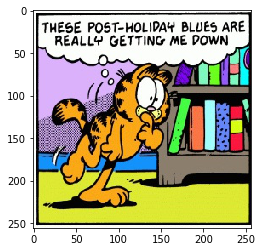

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torchvision
transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

img = Image.open('../garfield_data_single/1991/1_1.jpeg')


plt.imshow(img)

img = transform(img)


In [3]:
import os
import pandas as pd

path="../garfield_3paneldata/"
master_file_path = '../garfield_data_single/master_file.csv'
data = []
for year in range(1991,2020,1):
    csv_path = os.path.join(path, "{}.csv".format(year))
    csv = pd.read_csv(csv_path, header=None)
    for i, row in csv.iterrows():
        if(not os.path.exists('../garfield_data_single/{}/{}_1.jpeg'.format(year, i))):
            continue
        entry = {'panel1': "{}/{}_1.jpeg".format(year, i),
                'panel2': "{}/{}_2.jpeg".format(year, i),
                'panel3': "{}/{}_3.jpeg".format(year, i),
                'text': row[2]}
        data.append(entry)

data = pd.DataFrame(data)

In [4]:
data.to_csv(master_file_path)
data = pd.read_csv(master_file_path, index_col=0)

In [11]:
import torchvision.models as models
from torch import nn

In [12]:
model = models.resnet18(pretrained=False)

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
from torch import nn

In [23]:
layers = [nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]\
        +list(model.children())[2:-1]\
        +[nn.Linear(in_features=512, out_features=128, bias=True)]

In [24]:
new_classifier = nn.Sequential(*layers)

In [25]:
new_classifier

Sequential(
  (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import numpy as np
import pandas as pd
import os
from PIL import Image

class GarfieldDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img1_name = os.path.join(self.root_dir,
                                self.data.iloc[idx, 0])
        img2_name = os.path.join(self.root_dir,
                                self.data.iloc[idx, 1])
        img3_name = os.path.join(self.root_dir,
                                self.data.iloc[idx, 2])
        image1 = Image.open(img1_name)
        image2 = Image.open(img2_name)
        
        text = self.data.iloc[idx, 3]
        input_text = 'None'
        output_text = 'None'
        if(" - - " in text or "- - " in text or " - -" in text or "- -" in text):
            delimeter = None
            for d in [" - - ", "- - ", " - -", "- -"]:
                if(d in text):
                    delimeter = d
                    break
            
            t = text.split(delimeter)
            if(t[0] != ''):
                input_text = t[0]
            if(t[1] != ''):
                output_text = t[1]
        else:
            print(text, self.data.iloc[idx, 0])
            t = text.split("- ")
            print(t)
            if(len(t) == 1):
                pass
            if(len(t) == 2):
                pass
            if(t[0] != ''):
                input_text = t[0]
            if(t[1] != ''):
                input_text = input_text + " - " + t[1]
            if(t[2] != ''):
                output_text = t[2]

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        image = torch.cat((image1, image2), 0)
        
        sample = {'image': image, 
                  'input_text': input_text,
                  'output_text': output_text
                 }

        return sample
    
    
dataset = GarfieldDataset('../garfield_data_single/master_file.csv', "../garfield_data_single/", transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ]))

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=16,
                        shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16,
                        shuffle=True, num_workers=2)

In [28]:
for x in train_dataloader:
    print(x['image'].shape)
    break

Ah, my high school garuation. - I remember when they called my name. - "Ron Arbuckle". Thanks for sharing, Ron. 2014/121_1.jpeg
['Ah, my high school garuation. ', 'I remember when they called my name. ', '"Ron Arbuckle". Thanks for sharing, Ron.']
This shouldn't take long. - FIVE MINUTES LATER: - Help. Smile for the Internet. 2015/303_1.jpeg
["This shouldn't take long. ", 'FIVE MINUTES LATER: ', 'Help. Smile for the Internet.']
STAY OFF THE GRASS - STAY OFF THE GRASS - STAY OFF THE "STAY OFF THE GRASS" SIGN Oh, come on! 2017/109_1.jpeg
['STAY OFF THE GRASS ', 'STAY OFF THE GRASS ', 'STAY OFF THE "STAY OFF THE GRASS" SIGN Oh, come on!']
Bad date, Garfield. - We went to a petting zoo... - And a goat ate my pants. Nice teddy bear boxers. 2005/110_1.jpeg
['Bad date, Garfield. ', 'We went to a petting zoo... ', 'And a goat ate my pants. Nice teddy bear boxers.']
Jon isn't going to be happy. - Woo hoo! Woo hoo! - The mice have been frolicking in his stamp collection. I'm Bolivia! 2013/198_1.

In [6]:
" - - ".split(" - - ")[1] == ''

True